<a href="https://colab.research.google.com/github/aziegert/Classification_Spaceship_Titanic/blob/main/Classification_Spaceship_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

In this project, I want to predict wether a passenger was transported to an alternate dimension durong the Spaceship Titanic's collision with the spacetime anomaly.
This competition is provided on kaggle:
https://www.kaggle.com/competitions/spaceship-titanic/

#Imports

In [ ]:
# !pip install opendatasets
# !pip install kaggle
# !pip install xgboost
# !pip install lightgbm
!pip install optuna
!pip install ydata-profiling
!pip install miceforest --no-cache-dir
!pip install catboost

In [ ]:
#Basic
from google.colab import files
import pandas as pd
import numpy as np
#EDA
from ydata_profiling import ProfileReport
import miceforest as mf
import missingno as msno
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#Modeling
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score, precision_score, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
import optuna
from xgboost import XGBClassifier
import lightgbm as lgb
import catboost

import warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline

#Loading data

In [ ]:
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!mkdir /root/kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c spaceship-titanic

In [ ]:
!unzip /content/spaceship-titanic.zip

Archive:  /content/spaceship-titanic.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [ ]:
df_train['type'] = 'train'
df_test['type'] = 'test'

df_ = pd.concat([df_train, df_test])
df_ = df_.reset_index(drop=True)

#EDA

##Data review

In [ ]:
df_.sample(5)

PassengerId HomePlanet CryoSleep    Cabin  Destination   Age    VIP  \
6575      6934_02       Mars     False  E/443/P  55 Cancri e  16.0  False   
4083      4359_02     Europa     False  C/137/P  55 Cancri e  40.0  False   
9275      1204_01      Earth     False   E/75/P  TRAPPIST-1e  26.0  False   
10181     3190_02       Mars      True  E/210/S  TRAPPIST-1e  48.0  False   
3796      4050_01     Europa     False   A/35/P  55 Cancri e  36.0  False   

       RoomService  FoodCourt  ShoppingMall     Spa   VRDeck             Name  \
6575        1228.0        0.0         450.0   446.0      NaN     Bleark Nutty   
4083           0.0    17687.0           0.0   425.0    155.0   Strali Sebleve   
9275           0.0        0.0         995.0     2.0      0.0              NaN   
10181          0.0        0.0           0.0     0.0      0.0      Carves Bert   
3796           0.0     1302.0           0.0  2067.0  10173.0  Decruxa Dissper   

      Transported   type  
6575        False  train  
4083         True  train  
9275          NaN   test  
10181         NaN   test  
3796        False  train

In [ ]:
#Basic metrics
df_.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  12700.000000  12707.000000  12681.000000  12664.000000  12686.000000   
mean      28.771969    222.897852    451.961675    174.906033    308.476904   
std       14.387261    647.596664   1584.370747    590.558690   1130.279641   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       19.000000      0.000000      0.000000      0.000000      0.000000   
50%       27.000000      0.000000      0.000000      0.000000      0.000000   
75%       38.000000     49.000000     77.000000     29.000000     57.000000   
max       79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count  12702.000000  
mean     306.789482  
std     1180.097223  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       42.000000  
max    24133.000000

In [ ]:
df_train.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000

In [ ]:
df_test.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  4186.000000   4195.000000   4171.000000   4179.000000   4176.000000   
mean     28.658146    219.266269    439.484296    177.295525    303.052443   
std      14.179072    607.011289   1527.663045    560.821123   1117.186015   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      26.000000      0.000000      0.000000      0.000000      0.000000   
75%      37.000000     53.000000     78.000000     33.000000     50.000000   
max      79.000000  11567.000000  25273.000000   8292.000000  19844.000000   

             VRDeck  
count   4197.000000  
mean     310.710031  
std     1246.994742  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       36.000000  
max    22272.000000

In [ ]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
 14  type          12970 non-null  object 
dtypes: float64(6), object(9)
memory usage: 1.5+ MB


In [ ]:
#Duplicated values
df_.duplicated().sum()

0

In [ ]:
df_.iloc[:,:-2].isnull().sum().sort_values(ascending=False)

CryoSleep       310
ShoppingMall    306
Cabin           299
VIP             296
Name            294
FoodCourt       289
HomePlanet      288
Spa             284
Destination     274
Age             270
VRDeck          268
RoomService     263
PassengerId       0
dtype: int64

In [ ]:
#Number of all missing values
df_.iloc[:,:-2].isnull().sum().sum()

3441

<Axes: >

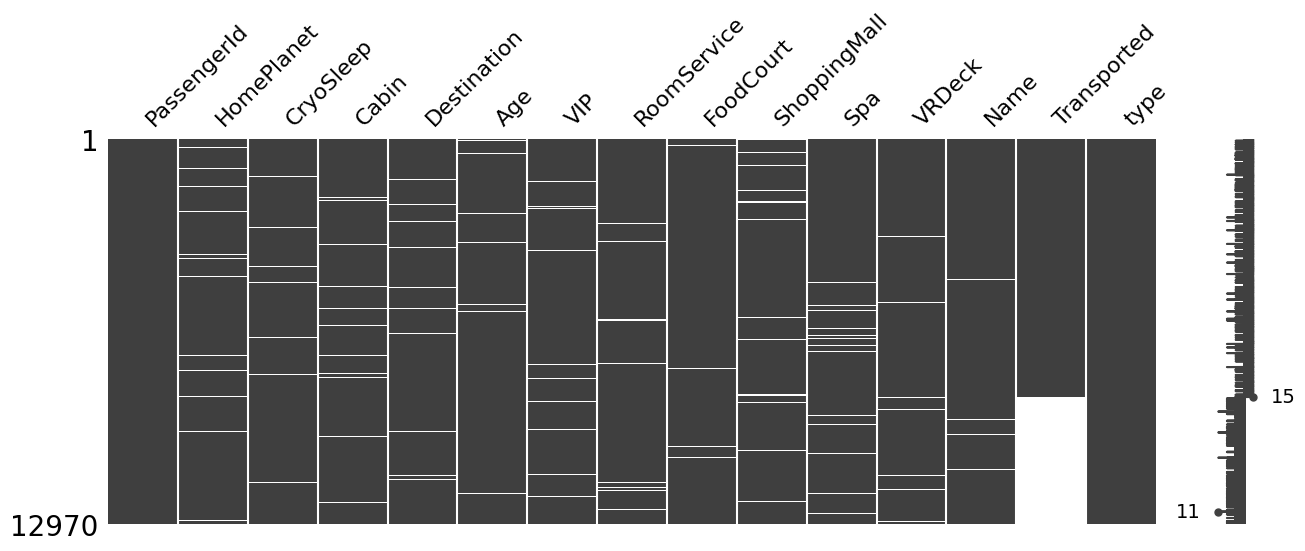

In [ ]:
msno.matrix(df_, figsize=(15,5))

<Axes: >

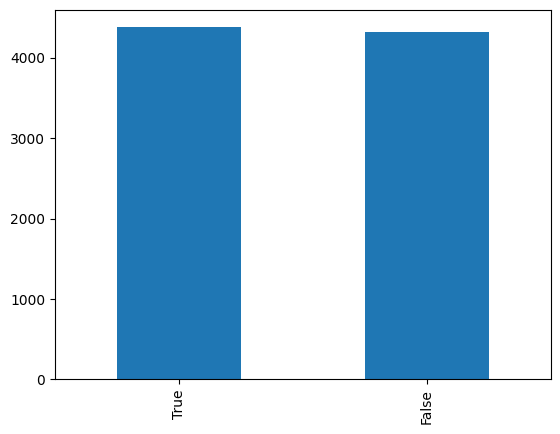

In [ ]:
#Train set is balanced
df_train.Transported.value_counts().plot(kind="bar")

<Axes: >

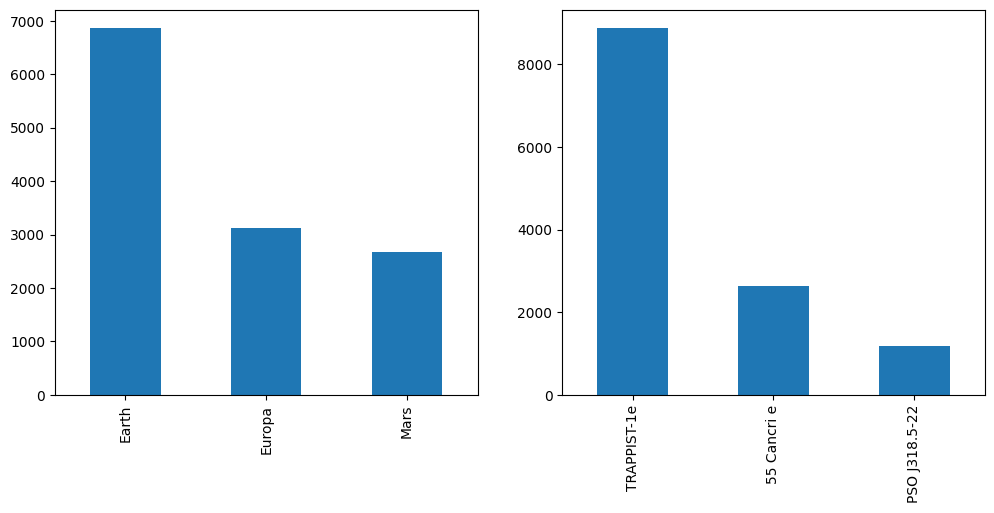

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

df_.HomePlanet.value_counts().plot(kind='bar', ax=ax1)
df_.Destination.value_counts().plot(kind='bar', ax=ax2)

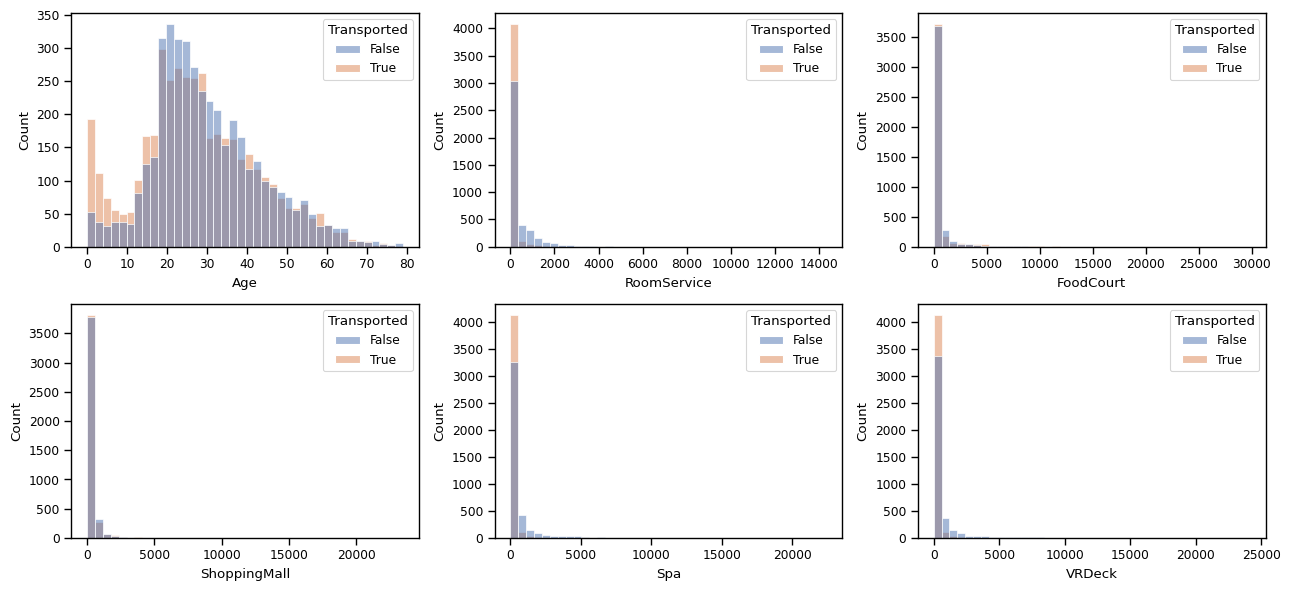

In [ ]:
df_hist = df_[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported']]

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(13, 6))
index = 0
axs = axs.flatten()
for k,v in df_hist.items():
    # sns.color_palette("pastel")
    sns.histplot(data=df_hist, x=v, bins=40, hue='Transported', edgecolor='white', ax=axs[index], palette='deep')
    index = index + 1
    if index == 6:
      break

plt.tight_layout()

##Profile Report

In [ ]:
prof_report = ProfileReport(df_, title="Profiling Report")
prof_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
prof_report.to_file("Profile_Report_Classification_Spaceship_Titanic.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#Preprocessing

##Changes in the notation of values

>Split columns:
 - 'PassengerId' into two columns: 'Id_Group', 'Id_NumInGroup'.
 - 'Cabin' into three columns: 'C_Deck', 'C_NumOnDeck', 'C_Side'.
 - 'Name' into two columns: 'Firstname', 'Surname'

 >Changing type of column 'C_NumOnDeck' from object to int

 >Changing bool values to 0-1 in columns: 'CryoSleep', 'VIP', 'Transported'


In [ ]:
df_[['Id_Group', 'Id_NumInGroup']] = df_['PassengerId'].str.split('_', expand=True).astype(int)

df_[['C_Deck', 'C_NumOnDeck', 'C_Side']] = df_['Cabin'].str.split('/', expand=True)
df_['C_NumOnDeck'] = df_['C_NumOnDeck'].map(lambda x: x if pd.isnull(x) else int(x))

df_[['Firstname', 'Surname']] = df_['Name'].str.split(' ', expand=True)

bool_col = ['CryoSleep', 'VIP', 'Transported']

df_[bool_col] = df_[bool_col].replace({True: 1, False: 0}).applymap(lambda x: x if pd.isnull(x) else int(x))

df_.sample(5)

PassengerId HomePlanet  CryoSleep    Cabin    Destination   Age  VIP  \
1315      1393_01       Mars        0.0  F/270/S    TRAPPIST-1e  36.0  0.0   
10563     3989_03      Earth        0.0  G/655/S    TRAPPIST-1e   3.0  0.0   
2305      2479_01      Earth        1.0      NaN  PSO J318.5-22  21.0  0.0   
12182     7591_01      Earth        0.0  E/494/P    TRAPPIST-1e  29.0  0.0   
3853      4128_03       Mars        1.0  F/846/P    TRAPPIST-1e   4.0  0.0   

       RoomService  FoodCourt  ShoppingMall  ...               Name  \
1315          42.0        0.0         212.0  ...           Mes Kake   
10563          0.0        NaN           0.0  ...    Beula Hopperett   
2305           0.0        0.0           0.0  ...  Joela Gordanieves   
12182        150.0     1459.0           0.0  ...    Karay Wolfernan   
3853           0.0        NaN           0.0  ...        Guanch Pare   

       Transported   type  Id_Group Id_NumInGroup  C_Deck  C_NumOnDeck C_Side  \
1315           0.0  train      1393             1       F        270.0      S   
10563          NaN   test      3989             3       G        655.0      S   
2305           0.0  train      2479             1     NaN          NaN    NaN   
12182          NaN   test      7591             1       E        494.0      P   
3853           1.0  train      4128             3       F        846.0      P   

       Firstname      Surname  
1315         Mes         Kake  
10563      Beula    Hopperett  
2305       Joela  Gordanieves  
12182      Karay    Wolfernan  
3853      Guanch         Pare  

[5 rows x 22 columns]

##CryoSleep and Expenses

>From the description of the contest guidelines we can conclude that if a person is in cryosleep, he cannot spend money to buy additional services. Moreover, when filling in the missing information in the columns: RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, we should remember this same feature of cryosleep.

In [ ]:
exp_col = ['RoomService',	'FoodCourt',	'ShoppingMall',	'Spa',	'VRDeck']

df_['Expenses'] = df_[exp_col].sum(axis=1)

df_.loc[:,['CryoSleep']] = df_.apply(lambda x: 1 if x.Expenses == 0 and pd.isnull(x.CryoSleep) else x, axis=1)

In [ ]:
df_.loc[:,['RoomService']] = df_.apply(lambda x: 0 if x.CryoSleep and pd.isnull(x.RoomService) else x, axis=1)
df_.loc[:,['FoodCourt']] = df_.apply(lambda x: 0 if x.CryoSleep and pd.isnull(x.FoodCourt) else x, axis=1)
df_.loc[:,['ShoppingMall']] = df_.apply(lambda x: 0 if x.CryoSleep and pd.isnull(x.ShoppingMall) else x, axis=1)
df_.loc[:,['Spa']] = df_.apply(lambda x: 0 if x.CryoSleep and pd.isnull(x.Spa) else x, axis=1)
df_.loc[:,['VRDeck']] = df_.apply(lambda x: 0 if x.CryoSleep and pd.isnull(x.VRDeck) else x, axis=1)

##New feature - 'No_Expenses'

In [ ]:
df_['No_Expenses'] = df_['Expenses'].apply(lambda x: 1 if x == 0 else 0)

##Age and Expenses

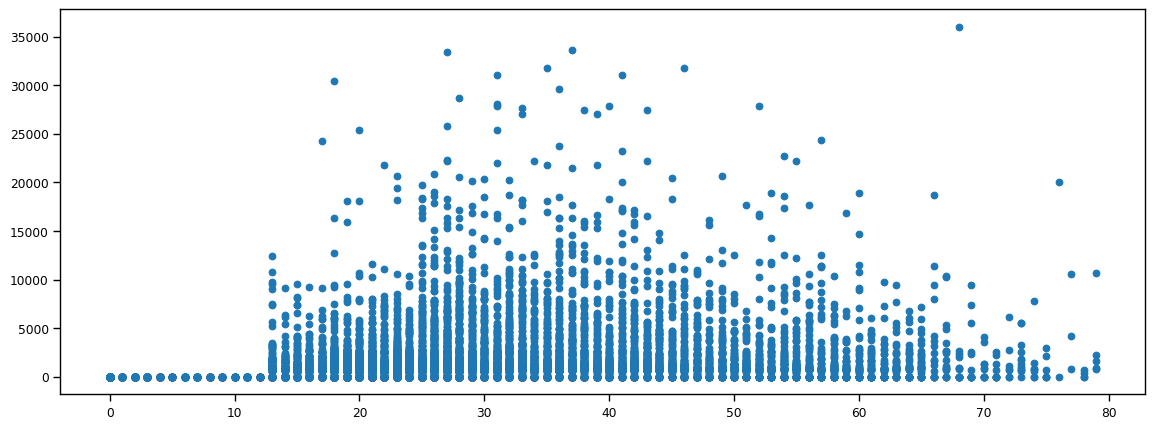

In [ ]:
fig, ax = plt.subplots(figsize=(14,5))
ax.scatter(df_['Age'],df_['Expenses'])

In [ ]:
df_[(df_['Age'] < 13) & (df_['Expenses'] > 0)].sum().sum()

0.0

>For people under 13 'Expenses' is equal to 0. We can use this information to complete the next nulls.

In [ ]:
df_.loc[:,['RoomService']] = df_.apply(lambda x: 0 if x.Age<13 and pd.isnull(x.RoomService) else x, axis=1)
df_.loc[:,['FoodCourt']] = df_.apply(lambda x: 0 if x.Age<13 and pd.isnull(x.FoodCourt) else x, axis=1)
df_.loc[:,['ShoppingMall']] = df_.apply(lambda x: 0 if x.Age<13 and pd.isnull(x.ShoppingMall) else x, axis=1)
df_.loc[:,['Spa']] = df_.apply(lambda x: 0 if x.Age<13 and pd.isnull(x.Spa	) else x, axis=1)
df_.loc[:,['VRDeck']] = df_.apply(lambda x: 0 if x.Age<13 and pd.isnull(x.VRDeck) else x, axis=1)

##Age and VIP

>For people under 13 'Expenses' is equal to 0. We can use this information to complete the next nulls.

In [ ]:
df_[(df_['Age'] < 18) & (df_['VIP'])].sum().sum()

0.0

In [ ]:
df_.loc[:,['VIP']] = df_.apply(lambda x: 0 if x.Age<18 and pd.isnull(x.VIP) else x, axis=1)

In [ ]:
df_[(df_['Age'] < 18) & (df_['VIP'].isnull())].sum().sum()

0.0

##HomePlanet and Id_Group

>We want to know if everyone in the group is from the same 'HomePlanet

In [ ]:
group_homeplanet = df_.groupby(['Id_Group', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
group_homeplanet.sample(5)

HomePlanet  Earth  Europa  Mars
Id_Group                       
5461          0.0     1.0   0.0
1030          1.0     0.0   0.0
5544          0.0     0.0   1.0
7718          0.0     1.0   0.0
6553          1.0     0.0   0.0

In [ ]:
group_homeplanet['n_planet'] = (group_homeplanet>0).sum(axis=1)
group_homeplanet.sample(5)

HomePlanet  Earth  Europa  Mars  n_planet
Id_Group                                 
4987          1.0     0.0   0.0         1
8611          1.0     0.0   0.0         1
7394          1.0     0.0   0.0         1
5742          1.0     0.0   0.0         1
41            1.0     0.0   0.0         1

In [ ]:
group_homeplanet['n_planet'].unique()

array([1])

In [ ]:
dict_gp = df_[['Id_Group', 'HomePlanet']]
dict_gp = dict_gp.dropna()
dict_gp = dict_gp.drop_duplicates(subset=['Id_Group'])

In [ ]:
dict_gp = dict_gp.to_dict(orient='records')
dict_gp = {row['Id_Group']: row['HomePlanet'] for row in dict_gp}

In [ ]:
df_.loc[:,['HomePlanet']] = df_.apply(lambda x: dict_gp.get(x.Id_Group, np.nan) if pd.isnull(x.HomePlanet) else x, axis=1)

##HomePlanet and C_Deck

- Passengers on decks A, B, C or T came from Europa.

-  Passengers on deck G came from Earth.

In [ ]:
deck_homeplanet = df_.groupby(['HomePlanet', 'C_Deck'])['C_Deck'].size().unstack().fillna(0)
deck_homeplanet

C_Deck          A       B       C      D      E       F       G     T
HomePlanet                                                           
Earth         0.0     0.0     0.0    0.0  589.0  2437.0  3731.0   0.0
Europa      352.0  1137.0  1096.0  301.0  199.0     0.0     0.0  10.0
Mars          0.0     0.0     0.0  410.0  515.0  1742.0     0.0   0.0

In [ ]:
dict_deck = {'A': 'Europa', 'B': 'Europa', 'C': 'Europa', 'T': 'Europa', 'G': 'Earth'}

In [ ]:
df_.loc[:,['HomePlanet']] = df_.apply(lambda x: dict_deck.get(x.C_Deck, np.nan) if pd.isnull(x.HomePlanet) else x, axis=1)

##C_Deck and Id_Group

In [ ]:
group_side = df_.groupby(['Id_Group', 'C_Side'])['C_Side'].size().unstack().fillna(0)
group_side.sample(5)

C_Side      P    S
Id_Group          
8587      1.0  0.0
778       0.0  2.0
141       1.0  0.0
1026      0.0  1.0
7628      2.0  0.0

In [ ]:
group_side['n_side'] = (group_side>0).sum(axis=1)
group_side.sample(5)

C_Side      P    S  n_side
Id_Group                  
5077      1.0  0.0       1
8444      1.0  0.0       1
1576      1.0  0.0       1
6423      0.0  1.0       1
1097      0.0  1.0       1

In [ ]:
group_side['n_side'].unique()

array([1])

In [ ]:
dict_gs = df_[['Id_Group', 'C_Side']]
dict_gs = dict_gs.dropna()
dict_gs = dict_gs.drop_duplicates(subset=['Id_Group'])

In [ ]:
dict_gs = dict_gs.to_dict(orient='records')
dict_gs = {row['Id_Group']: row['C_Side'] for row in dict_gs}

In [ ]:
df_.loc[:,['C_Side']] = df_.apply(lambda x: dict_gs.get(x.Id_Group, np.nan) if pd.isnull(x.C_Side) else x, axis=1)

##Surame and HomePlanet

In [ ]:
surname_homeplanet = df_.groupby(['Surname', 'HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
surname_homeplanet.sample(5)

HomePlanet  Earth  Europa  Mars
Surname                        
Hendez        2.0     0.0   0.0
Unressind     0.0     2.0   0.0
Paynard       7.0     0.0   0.0
Puff          0.0     0.0   1.0
Mcguirez      7.0     0.0   0.0

In [ ]:
surname_homeplanet['n_planet'] = (surname_homeplanet>0).sum(axis=1)
surname_homeplanet.sample(5)

HomePlanet  Earth  Europa  Mars  n_planet
Surname                                  
Foraud        0.0     9.0   0.0         1
Vloaf         0.0     0.0  16.0         1
Cattle        0.0     3.0   0.0         1
Trallect      0.0     5.0   0.0         1
Ingwhed       0.0     5.0   0.0         1

In [ ]:
surname_homeplanet['n_planet'].unique()

array([1])

In [ ]:
dict_sh = df_[['Surname', 'HomePlanet']]
dict_sh = dict_sh.dropna()
dict_sh = dict_sh.drop_duplicates(subset=['Surname'])

In [ ]:
dict_sh = dict_sh.to_dict(orient='records')
dict_sh = {row ['Surname']: row['HomePlanet'] for row in dict_sh}

In [ ]:
df_.loc[:,'HomePlanet'] = df_.apply(lambda x: dict_sh.get(x.Surname, np.nan) if pd.isnull(x.HomePlanet) else x, axis=1)

##Categorical data

###Option 1   Mapping of ordinal features

In [ ]:
def map_cat_columns_to_ord(dataframe, columns):
  label_dict = {}
  for col in columns:
    lst = list(filter(lambda x: x==x, df_[col].unique().tolist()))
    label_dict[col] = sorted(lst)
  for column in label_dict:
    mapping_dict = {}
    for i, label in enumerate(label_dict[column]):
      mapping_dict[label] = i+1
    new_column = column + '_ord'
    dataframe[new_column] = dataframe[column].map(mapping_dict)
  return dataframe

In [ ]:
cat_col = ['C_Deck', 'C_Side', 'HomePlanet', 'Destination']

df1 = map_cat_columns_to_ord(df_, cat_col)

df1.sample(5)

PassengerId HomePlanet  CryoSleep     Cabin    Destination   Age  VIP  \
7154     7632_01       Mars        0.0   D/226/S    TRAPPIST-1e  28.0  0.0   
6722     7092_01      Earth        0.0  F/1470/P    TRAPPIST-1e  24.0  0.0   
2947     3195_04      Earth        0.0   G/505/S  PSO J318.5-22  11.0  0.0   
8129     8683_01      Earth        0.0  F/1679/S  PSO J318.5-22  42.0  0.0   
91       0099_01      Earth        0.0    F/19/P  PSO J318.5-22  23.0  0.0   

      RoomService  FoodCourt  ShoppingMall  ...  C_NumOnDeck  C_Side  \
7154       2703.0        0.0           4.0  ...        226.0       S   
6722         61.0      397.0         185.0  ...       1470.0       P   
2947          0.0        0.0           0.0  ...        505.0       S   
8129         51.0        6.0          87.0  ...       1679.0       S   
91          311.0      427.0         526.0  ...         19.0       P   

     Firstname      Surname Expenses  No_Expenses  C_Deck_ord C_Side_ord  \
7154      Phex        Kepie   2708.0            0         4.0        2.0   
6722      Sall  Gaineyerson    644.0            0         6.0        1.0   
2947     Ralda     Litthews      0.0            1         7.0        2.0   
8129    Dandra      Prinson    569.0            0         6.0        2.0   
91       Aliey  Leetersoney   1301.0            0         6.0        1.0   

      HomePlanet_ord Destination_ord  
7154             3.0             3.0  
6722             1.0             3.0  
2947             1.0             2.0  
8129             1.0             2.0  
91               1.0             2.0  

[5 rows x 28 columns]

###Option 2  One-hot encoding

In [ ]:
df2 = pd.get_dummies(df_, columns=cat_col)

df2.sample(5)

PassengerId  CryoSleep    Cabin   Age  VIP  RoomService  FoodCourt  \
151      0172_01        1.0   G/24/P  32.0  0.0          0.0        0.0   
9922     2608_01        1.0  G/415/S  22.0  0.0          0.0        0.0   
9579     1838_01        1.0  F/363/P  35.0  0.0          0.0        0.0   
3007     3258_01        1.0  G/529/P   9.0  0.0          0.0        0.0   
4137     4415_01        0.0  F/833/S  45.0  0.0        941.0      281.0   

      ShoppingMall   Spa  VRDeck  ... C_Deck_G  C_Deck_T C_Side_P  C_Side_S  \
151            0.0   0.0     0.0  ...        1         0        1         0   
9922           0.0   0.0     0.0  ...        1         0        0         1   
9579           0.0   0.0     0.0  ...        0         0        1         0   
3007           0.0   0.0     0.0  ...        1         0        1         0   
4137          36.0  12.0    39.0  ...        0         0        0         1   

      HomePlanet_Earth  HomePlanet_Europa HomePlanet_Mars  \
151                  1                  0               0   
9922                 1                  0               0   
9579                 0                  0               1   
3007                 1                  0               0   
4137                 0                  0               1   

     Destination_55 Cancri e  Destination_PSO J318.5-22  \
151                        0                          0   
9922                       0                          0   
9579                       0                          0   
3007                       0                          0   
4137                       0                          0   

      Destination_TRAPPIST-1e  
151                         1  
9922                        1  
9579                        1  
3007                        1  
4137                        1  

[5 rows x 40 columns]

##Only numerical columns

In [ ]:
df_numerical = df1.select_dtypes(include='number')

In [ ]:
df_numerical.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'Id_Group', 'Id_NumInGroup',
       'C_NumOnDeck', 'Expenses', 'No_Expenses', 'C_Deck_ord', 'C_Side_ord',
       'HomePlanet_ord', 'Destination_ord'],
      dtype='object')

In [ ]:
Transported_col = df_numerical.pop('Transported')
df_numerical['Transported'] = Transported_col

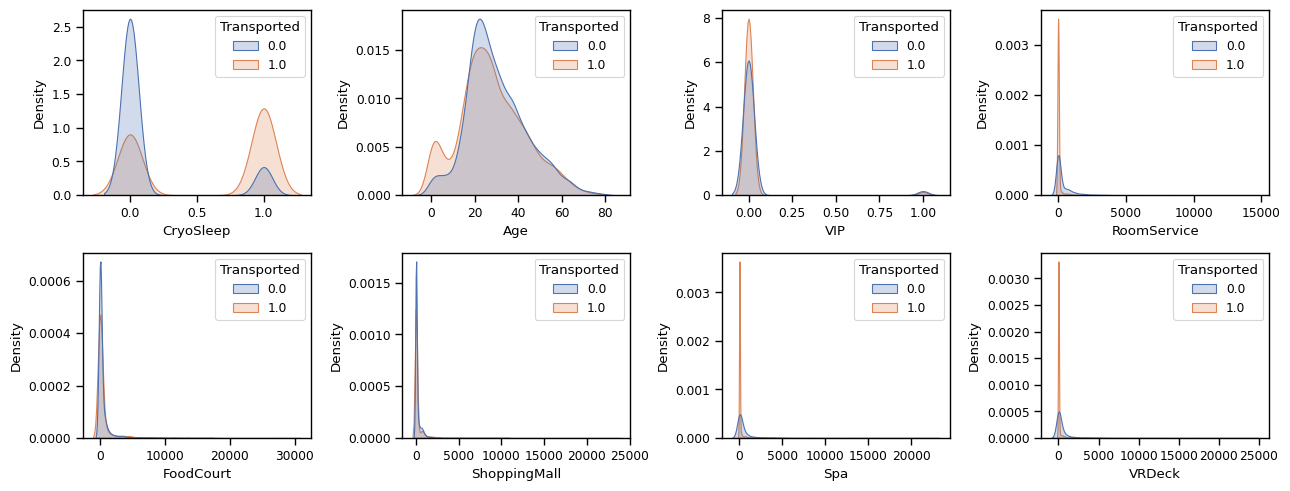

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(13,5))
index = 0
axs = axs.flatten()
for k,v in df_numerical.iloc[:,:8].items():
    sns.kdeplot(data=df_numerical, x=v, ax=axs[index], hue='Transported', fill=True, palette='deep')
    index = index + 1

plt.tight_layout()

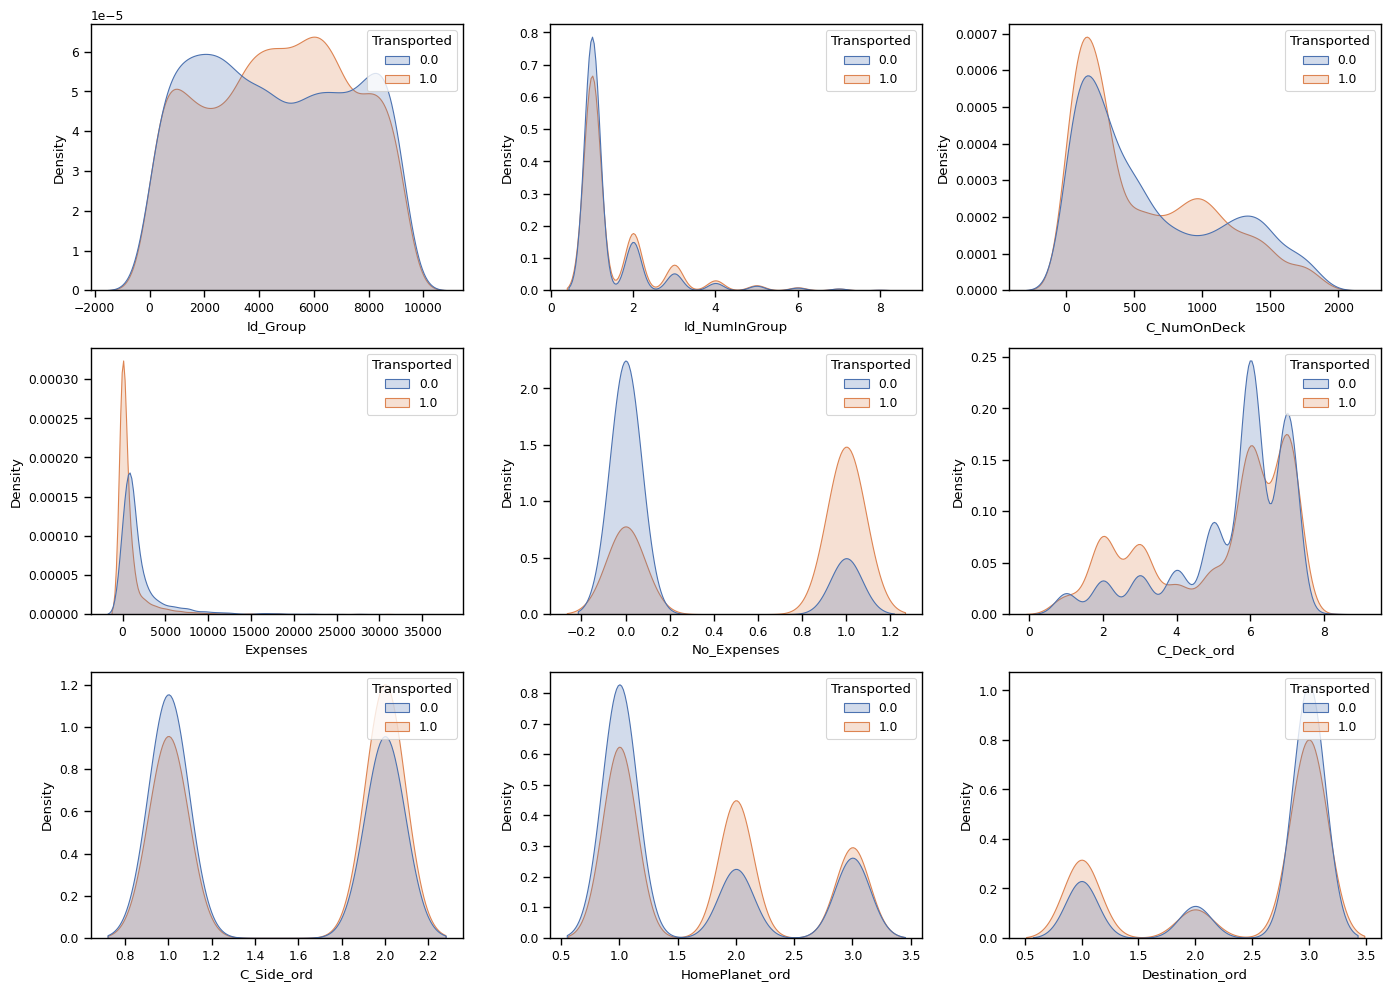

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(14,10))
index = 0
axs = axs.flatten()
for k,v in df_numerical.iloc[:,8:].items():
    sns.kdeplot(data=df_numerical, x=v, ax=axs[index], hue='Transported', fill=True, palette='deep')
    index = index + 1
    if index == 9:
      break

plt.tight_layout()

<Axes: >

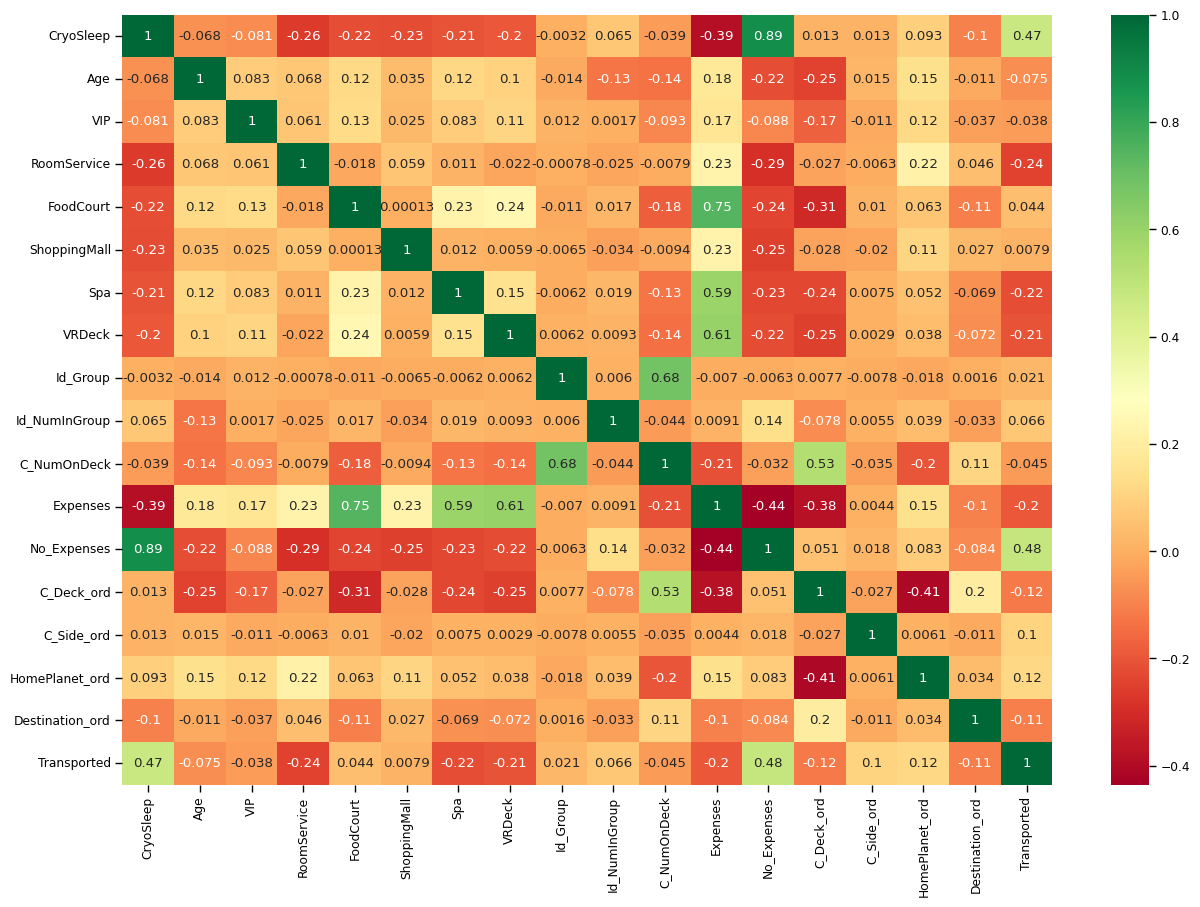

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df_numerical.corr(), cmap='RdYlGn', annot=True)

##Filling missing values

###Option 1

In [ ]:
df1.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'type', 'Id_Group', 'Id_NumInGroup', 'C_Deck',
       'C_NumOnDeck', 'C_Side', 'Firstname', 'Surname', 'Expenses',
       'No_Expenses', 'C_Deck_ord', 'C_Side_ord', 'HomePlanet_ord',
       'Destination_ord'],
      dtype='object')

In [ ]:
df1_m = df_[['Id_Group', 'Id_NumInGroup', 'HomePlanet_ord', 'CryoSleep',
          'C_Deck_ord', 'C_Side_ord', 'C_NumOnDeck', 'Destination_ord',
          'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
          'Spa', 'VRDeck', 'No_Expenses', 'Transported']]

In [ ]:
imk1 = mf.ImputationKernel(df1_m, save_all_iterations=True, random_state=6)

imk1.mice(5)

In [ ]:
df1 = imk1.complete_data()

In [ ]:
df1.isnull().sum().sum()

0

###Option 2

In [ ]:
df2.columns

Index(['PassengerId', 'CryoSleep', 'Cabin', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported',
       'type', 'Id_Group', 'Id_NumInGroup', 'C_NumOnDeck', 'Firstname',
       'Surname', 'Expenses', 'No_Expenses', 'C_Deck_ord', 'C_Side_ord',
       'HomePlanet_ord', 'Destination_ord', 'C_Deck_A', 'C_Deck_B', 'C_Deck_C',
       'C_Deck_D', 'C_Deck_E', 'C_Deck_F', 'C_Deck_G', 'C_Deck_T', 'C_Side_P',
       'C_Side_S', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
       'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e'],
      dtype='object')

In [ ]:
df2_m = df2[['Id_Group', 'Id_NumInGroup',
            'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
            'CryoSleep',
            'C_Deck_A', 'C_Deck_B', 'C_Deck_C', 'C_Deck_D', 'C_Deck_E',
            'C_Deck_F', 'C_Deck_G', 'C_Deck_T',
            'C_Side_P', 'C_Side_S',
            'C_NumOnDeck',
            'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
            'Destination_TRAPPIST-1e',
            'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 
            'Spa', 'VRDeck', 'No_Expenses', 'Transported']]

In [ ]:
imk2 = mf.ImputationKernel(df2_m, save_all_iterations=True, random_state=6)

imk2.mice(5)

In [ ]:
df2 = imk2.complete_data()

In [ ]:
df2.isnull().sum().sum()

0

#Modeling

##Metrics

In [ ]:
skf = StratifiedKFold(n_splits=5)

In [ ]:
def calculate_metrics(y, y_pred):       
    metrics = {'F1': [round(f1_score(y, y_pred),4)],
               'P-R': [round(average_precision_score(y, y_pred),4)],
               'accuracy': [round(accuracy_score(y, y_pred),4)],
               'recall': [round(recall_score(y, y_pred),4)],
               'precision': [round(precision_score(y, y_pred),4)],
               'AUC': [round(roc_auc_score(y, y_pred),4)]
                }
     
    return pd.DataFrame(metrics)

In [ ]:
def get_result(model, X_train, X_val, y_train, y_val):

  model.fit(X_train, y_train)

  y_train_pred = model.predict(X_train)
  metrics_train = calculate_metrics(y_train, y_train_pred)

  y_val_pred = model.predict(X_val)
  metrics_val = calculate_metrics(y_val, y_val_pred)

  metrics = pd.concat([metrics_train, metrics_val]).set_index([pd.Index(['TRAIN', 'VAL'])])

  return y_train_pred, y_val_pred, metrics


##Option 1

In [ ]:
X1 = df1.iloc[:8693,0:-1]
y1 = df1['Transported'].iloc[:8693]

In [ ]:
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size=0.3, stratify=y1, random_state=6)

print('Train set: ' + str(X1_train.shape[0]) + ' records')
print('Validation set: ' + str(X1_val.shape[0]) + ' records')

Train set: 6085 records
Validation set: 2608 records


###XGBoost

In [ ]:
def objective_1_XGB(trial):

    params = {  
        'objective': 'binary:hinge',
        'eval_metric': 'error',
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.14),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'lambda': trial.suggest_float('lambda', 1, 10),
        'alpha': trial.suggest_float('alpha', 1, 10),        
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 6
         }

    optuna_model = XGBClassifier(**params)

    cvs = cross_val_score(optuna_model,
                          cv=skf,
                          X=X1_train,
                          y=y1_train,
                          scoring='accuracy')
    score = cvs.mean()

    return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=6)
study_1_XGB = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-03-30 12:41:06,461] A new study created in memory with name: no-name-1ddef7a0-fe02-4a88-840b-1d5d9599c24a


In [ ]:
study_1_XGB.optimize(objective_1_XGB, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-03-30 12:41:26,967] Trial 0 finished with value: 0.7875102711585866 and parameters: {'learning_rate': 0.13571440605744006, 'n_estimators': 199, 'max_depth': 8, 'lambda': 1.375269631527249, 'alpha': 1.9689101194237115, 'colsample_bytree': 0.5991015435641779, 'subsample': 0.5345191885708934, 'min_child_weight': 5}. Best is trial 0 with value: 0.7875102711585866.
[I 2023-03-30 12:41:32,646] Trial 1 finished with value: 0.8008216926869351 and parameters: {'learning_rate': 0.11341631397093317, 'n_estimators': 330, 'max_depth': 4, 'lambda': 7.622938957138212, 'alpha': 5.662327707993419, 'colsample_bytree': 0.5830700142238955, 'subsample': 0.6489015449366379, 'min_child_weight': 10}. Best is trial 1 with value: 0.8008216926869351.
[I 2023-03-30 12:41:44,210] Trial 2 finished with value: 0.7975349219391947 and parameters: {'learning_rate': 0.13279432787687367, 'n_estimators': 236, 'max_depth': 8, 'lambda': 8.413834893134691, 'alpha': 1.4902705704011918, 'colsample_bytree': 0.7214508641

In [ ]:
params_1_XGB = study_1_XGB.best_params
params_1_XGB

{'learning_rate': 0.12939571440994013,
 'n_estimators': 429,
 'max_depth': 7,
 'lambda': 9.213984570667098,
 'alpha': 8.14116443466107,
 'colsample_bytree': 0.3993336962013011,
 'subsample': 0.5496090498653813,
 'min_child_weight': 4}

In [ ]:
model_1_XGB = XGBClassifier(**params_1_XGB, random_state=6)
y_train_1_XGB, y_val_1_XGB, metrics_1_XGB = get_result(model_1_XGB, X1_train, X1_val, y1_train, y1_val)
metrics_1_XGB

F1     P-R  accuracy  recall  precision     AUC
TRAIN  0.8616  0.8112    0.8603  0.8633     0.8599  0.8603
VAL    0.8196  0.7548    0.8148  0.8355     0.8043  0.8147

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_1_XGB)

In [ ]:
optuna.visualization.plot_optimization_history(study_1_XGB)

###LightGBM

In [ ]:
def objective_1_GBM(trial):
    
    params = {        
        'metric': 'accuracy',
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'categorical_feature': [2, 4, 5, 7],
        'random_state': 6,
        'verbose': -1,
        }

    optuna_model = lgb.LGBMClassifier(**params)

    cvs = cross_val_score(optuna_model,
                          cv=skf,
                          X=X1_train,
                          y=y1_train,
                          scoring='accuracy')
    score = cvs.mean()
    
    return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=6)
study_1_GBM = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-03-30 20:37:37,266] A new study created in memory with name: no-name-43ca1bf4-c2cb-4cc1-be85-66fa95e8ee32


In [ ]:
study_1_GBM.optimize(objective_1_GBM, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-03-30 20:37:42,173] Trial 0 finished with value: 0.7968775677896467 and parameters: {'max_depth': 11, 'n_estimators': 199, 'learning_rate': 0.24815644568677123, 'num_leaves': 31, 'min_child_samples': 15, 'colsample_bytree': 0.7975260321031201, 'subsample': 0.7649086810964107}. Best is trial 0 with value: 0.7968775677896467.
[I 2023-03-30 20:37:43,386] Trial 1 finished with value: 0.8003286770747741 and parameters: {'max_depth': 7, 'n_estimators': 201, 'learning_rate': 0.19053063533686615, 'num_leaves': 143, 'min_child_samples': 75, 'colsample_bytree': 0.7590182059996344, 'subsample': 0.7894293001130785}. Best is trial 1 with value: 0.8003286770747741.
[I 2023-03-30 20:37:49,857] Trial 2 finished with value: 0.7924404272801973 and parameters: {'max_depth': 9, 'n_estimators': 496, 'learning_rate': 0.247758877107334, 'num_leaves': 136, 'min_child_samples': 89, 'colsample_bytree': 0.9118797162852607, 'subsample': 0.5272372539111774}. Best is trial 1 with value: 0.8003286770747741.


In [ ]:
params_1_GBM = study_1_GBM.best_params
params_1_GBM

{'max_depth': 3,
 'n_estimators': 83,
 'learning_rate': 0.26681712604825575,
 'num_leaves': 227,
 'min_child_samples': 26,
 'colsample_bytree': 0.9630668960834897,
 'subsample': 0.9973739898614384}

In [ ]:
model_1_GBM = lgb.LGBMClassifier(**params_1_GBM, random_state=6)
y_train_1_GBM, y_val_1_GBM, metrics_1_GBM = get_result(model_1_GBM, X1_train, X1_val, y1_train, y1_val)
metrics_1_GBM

F1     P-R  accuracy  recall  precision     AUC
TRAIN  0.850  0.7898    0.8459  0.8669     0.8337  0.8457
VAL    0.815  0.7436    0.8071  0.8439     0.7881  0.8069

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_1_GBM)

In [ ]:
optuna.visualization.plot_optimization_history(study_1_GBM)

###CatBoost

In [ ]:
def objective_1_CB(trial):
    
    params = {
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'l2_leaf_reg': trial.suggest_uniform('l2_leaf_reg', 0.1, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'eval_metric': 'Accuracy',
        'random_state': 6,
        'thread_count': 4,
        'verbose': False
        }

    optuna_model = catboost.CatBoostClassifier(**params)

    cvs = cross_val_score(optuna_model,
                      cv=skf,
                      X=X1_train,
                      y=y1_train,
                      scoring='accuracy')
    score = cvs.mean()
    
    return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=6)
study_1_CB = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-03-30 13:30:12,414] A new study created in memory with name: no-name-9fbcf685-1338-41a0-aeba-5a9929f7869f


In [ ]:
study_1_CB.optimize(objective_1_CB, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-03-30 13:30:30,917] Trial 0 finished with value: 0.8023007395234183 and parameters: {'learning_rate': 0.26892944391644047, 'max_depth': 6, 'l2_leaf_reg': 8.230168318272534, 'bagging_temperature': 0.0416966257252499, 'border_count': 56, 'n_estimators': 318}. Best is trial 0 with value: 0.8023007395234183.
[I 2023-03-30 13:30:39,019] Trial 1 finished with value: 0.8027937551355793 and parameters: {'learning_rate': 0.16364703503591826, 'max_depth': 6, 'l2_leaf_reg': 3.4205377078059596, 'bagging_temperature': 0.6225194321960902, 'border_count': 130, 'n_estimators': 381}. Best is trial 1 with value: 0.8027937551355793.
[I 2023-03-30 13:30:49,452] Trial 2 finished with value: 0.8073952341824157 and parameters: {'learning_rate': 0.16023055947978793, 'max_depth': 8, 'l2_leaf_reg': 6.489015449366379, 'bagging_temperature': 0.9902242713734164, 'border_count': 215, 'n_estimators': 236}. Best is trial 2 with value: 0.8073952341824157.
[I 2023-03-30 13:31:18,599] Trial 3 finished with value

In [ ]:
params_1_CB = study_1_CB.best_params
params_1_CB

{'learning_rate': 0.03470098077287444,
 'max_depth': 5,
 'l2_leaf_reg': 3.9417447444488074,
 'bagging_temperature': 0.36483196335441515,
 'border_count': 151,
 'n_estimators': 482}

In [ ]:
model_1_CB = catboost.CatBoostClassifier(**params_1_CB, random_seed=6, verbose=False)
y_train_1_CB, y_val_1_CB, metrics_1_CB = get_result(model_1_CB, X1_train, X1_val, y1_train, y1_val)
metrics_1_CB

F1     P-R  accuracy  recall  precision     AUC
TRAIN  0.8556  0.7977    0.8521  0.8701     0.8416  0.8520
VAL    0.8212  0.7507    0.8137  0.8500     0.7943  0.8134

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_1_CB)

In [ ]:
optuna.visualization.plot_optimization_history(study_1_CB)

##Option 2

In [ ]:
X2 = df2.iloc[:,0:-1]
y2 = df2['Transported']

In [ ]:
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=0.3, stratify=y2, random_state=6)

print('Train set: ' + str(X2_train.shape[0]) + ' records')
print('Validation set: ' + str(X2_val.shape[0]) + ' records')

Train set: 9079 records
Validation set: 3891 records


###XGBoost

In [ ]:
def objective_2_XGB(trial):

    params = {
        'objective': 'binary:hinge',
        'eval_metric': 'error',
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.14),
        'lambda': trial.suggest_float('lambda', 1, 10),
        'alpha': trial.suggest_float('alpha', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 6
           }

    optuna_model = XGBClassifier(**params)

    cvs = cross_val_score(optuna_model,
                          cv=skf,
                          X=X2_train,
                          y=y2_train,
                          scoring='accuracy')
    score = cvs.mean()
    
    return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=6)
study_2_XGB = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-03-30 14:24:30,962] A new study created in memory with name: no-name-691d6999-436a-4ec2-be71-dadbcbc3ec60


In [ ]:
study_2_XGB.optimize(objective_2_XGB, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-03-30 14:24:34,889] Trial 0 finished with value: 0.7478812757126734 and parameters: {'learning_rate': 0.13571440605744006, 'lambda': 3.987818247710595, 'alpha': 8.391062107520487, 'n_estimators': 68, 'max_depth': 1, 'colsample_bytree': 0.5991015435641779, 'subsample': 0.5345191885708934, 'min_child_weight': 5}. Best is trial 0 with value: 0.7478812757126734.
[I 2023-03-30 14:24:56,357] Trial 1 finished with value: 0.8120939066273468 and parameters: {'learning_rate': 0.11341631397093317, 'lambda': 6.6026748897648115, 'alpha': 4.943272834979867, 'n_estimators': 381, 'max_depth': 5, 'colsample_bytree': 0.5830700142238955, 'subsample': 0.6489015449366379, 'min_child_weight': 10}. Best is trial 1 with value: 0.8120939066273468.
[I 2023-03-30 14:25:02,270] Trial 2 finished with value: 0.7982166478562154 and parameters: {'learning_rate': 0.13279432787687367, 'lambda': 4.718808413345627, 'alpha': 8.886408896859646, 'n_estimators': 421, 'max_depth': 1, 'colsample_bytree': 0.721450864198

In [ ]:
params_2_XGB = study_2_XGB.best_params
params_2_XGB

{'learning_rate': 0.12341870138144453,
 'lambda': 4.3426793165103765,
 'alpha': 2.881906590915511,
 'n_estimators': 202,
 'max_depth': 4,
 'colsample_bytree': 0.7676544762154046,
 'subsample': 0.8107577119061824,
 'min_child_weight': 8}

In [ ]:
model_2_XGB = XGBClassifier(**params_2_XGB, random_state=6)
y_train_2_XGB, y_val_2_XGB, metrics_2_XGB = get_result(model_2_XGB, X2_train, X2_val, y2_train, y2_val)
metrics_2_XGB

F1     P-R  accuracy  recall  precision     AUC
TRAIN  0.8551  0.8030    0.8534  0.8576     0.8526  0.8534
VAL    0.8154  0.7543    0.8121  0.8226     0.8082  0.8120

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_2_XGB)

In [ ]:
optuna.visualization.plot_optimization_history(study_2_XGB)

###LightGBM

In [ ]:
def objective_2_GBM(trial):
    
    params = {
        'metric': 'accuracy',
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        # 'categorical_feature': [2, 4, 5, 7],
        'random_state': 6,
        'verbose': -1,
        }

    optuna_model = lgb.LGBMClassifier(**params)
    
    cvs = cross_val_score(optuna_model,
                          cv=skf,
                          X=X2_train,
                          y=y2_train,
                          scoring='accuracy')
    score = cvs.mean()
    
    return score

In [ ]:
optuna.samplers.TPESampler(seed=6)
study_2_GBM = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-03-30 15:26:43,487] A new study created in memory with name: no-name-7adb25bd-409d-4a9d-8fba-c8a44385de2a


In [ ]:
study_2_GBM.optimize(objective_2_GBM, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-03-30 15:26:46,265] Trial 0 finished with value: 0.8085697989102074 and parameters: {'n_estimators': 163, 'learning_rate': 0.0219988953772615, 'num_leaves': 289, 'max_depth': 3, 'min_child_samples': 54}. Best is trial 0 with value: 0.8085697989102074.
[I 2023-03-30 15:26:49,443] Trial 1 finished with value: 0.8032823023992428 and parameters: {'n_estimators': 203, 'learning_rate': 0.20140284740716535, 'num_leaves': 257, 'max_depth': 9, 'min_child_samples': 61}. Best is trial 0 with value: 0.8085697989102074.
[I 2023-03-30 15:26:52,987] Trial 2 finished with value: 0.8085693134792052 and parameters: {'n_estimators': 102, 'learning_rate': 0.2160305972784053, 'num_leaves': 77, 'max_depth': 7, 'min_child_samples': 8}. Best is trial 0 with value: 0.8085697989102074.
[I 2023-03-30 15:26:55,004] Trial 3 finished with value: 0.8033922525212072 and parameters: {'n_estimators': 192, 'learning_rate': 0.26027881805880915, 'num_leaves': 176, 'max_depth': 8, 'min_child_samples': 40}. Best is 

In [ ]:
params_2_GBM = study_2_GBM.best_params
params_2_GBM 

{'n_estimators': 57,
 'learning_rate': 0.12368462773332135,
 'num_leaves': 208,
 'max_depth': 4,
 'min_child_samples': 17}

In [ ]:
model_2_GBM = lgb.LGBMClassifier(**params_2_GBM, random_state=6)
y_train_2_GBM, y_val_2_GBM, metrics_2_GBM = get_result(model_2_GBM, X2_train, X2_val, y2_train, y2_val)
metrics_2_GBM

F1     P-R  accuracy  recall  precision     AUC
TRAIN  0.8415  0.7797    0.8369  0.8585     0.8251  0.8367
VAL    0.8182  0.7503    0.8116  0.8405     0.7970  0.8114

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_2_GBM)

In [ ]:
optuna.visualization.plot_optimization_history(study_2_GBM)

###CatBoost

In [ ]:
def objective_2_CB(trial):
    
    params = {
        'eval_metric': 'Accuracy',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_uniform('l2_leaf_reg', 0.1, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': False
        }

    optuna_model = catboost.CatBoostClassifier(**params)
    
    cvs = cross_val_score(optuna_model,
                          cv=skf,
                          X=X2_train,
                          y=y2_train,
                          scoring='accuracy')
    score = cvs.mean()
    
    return score

In [ ]:
optuna.samplers.TPESampler(seed=6)
study_2_CB = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-03-30 15:43:21,394] A new study created in memory with name: no-name-1bbf8abb-20c3-4e89-9578-1d2d0a14d346


In [ ]:
study_2_CB.optimize(objective_2_CB, n_trials=200, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-03-30 15:43:31,732] Trial 0 finished with value: 0.8054853096443004 and parameters: {'n_estimators': 286, 'max_depth': 5, 'learning_rate': 0.2570534539232839, 'l2_leaf_reg': 4.886685423094244, 'bagging_temperature': 0.6231499511360751, 'border_count': 249}. Best is trial 0 with value: 0.8054853096443004.
[I 2023-03-30 15:43:38,926] Trial 1 finished with value: 0.81055144961833 and parameters: {'n_estimators': 209, 'max_depth': 5, 'learning_rate': 0.2938270036316765, 'l2_leaf_reg': 5.912036767908046, 'bagging_temperature': 0.9816813887375007, 'border_count': 248}. Best is trial 1 with value: 0.81055144961833.
[I 2023-03-30 15:43:46,547] Trial 2 finished with value: 0.8127545175422629 and parameters: {'n_estimators': 368, 'max_depth': 3, 'learning_rate': 0.1877208129411087, 'l2_leaf_reg': 2.570635773494248, 'bagging_temperature': 0.12943570725402642, 'border_count': 114}. Best is trial 2 with value: 0.8127545175422629.
[I 2023-03-30 15:44:02,638] Trial 3 finished with value: 0.79

In [ ]:
params_2_CB = study_2_CB.best_params
params_2_CB

{'n_estimators': 119,
 'max_depth': 7,
 'learning_rate': 0.08705841344069595,
 'l2_leaf_reg': 2.463182805254788,
 'bagging_temperature': 0.9775171777033689,
 'border_count': 123}

In [ ]:
model_2_CB = catboost.CatBoostClassifier(**params_2_CB, random_seed=6, verbose=False)
y_train_2_CB, y_val_2_CB, metrics_2_CB = get_result(model_2_CB, X2_train, X2_val, y2_train, y2_val)
metrics_2_CB

F1     P-R  accuracy  recall  precision     AUC
TRAIN  0.8551  0.7986    0.8519  0.8666     0.8439  0.8517
VAL    0.8218  0.7579    0.8170  0.8369     0.8073  0.8168

#Experiment evaluation

##Algorithms used:

- XGBoost classifier is a gradient boosting algorithm that uses a combination of decision trees and boosting to achieve high accuracy and performance in machine learning tasks.

- LightGBM classifier is a gradient boosting algorithm that uses a combination of decision trees and histogram-based techniques to achieve high efficiency and scalability in machine learning tasks.

- CatBoost classifier is a gradient boosting algorithm that uses a combination of ordered boosting and gradient-based leaf optimization to achieve high accuracy and performance in machine learning tasks.

##Summary of results

>Option 1
 Categorical features mapped to ordinal features

In [ ]:
result_1 = pd.concat([metrics_1_XGB, metrics_1_GBM, metrics_1_CB], keys=['XGBoost', 'LightGBM', 'CatBoost'])
result_1

F1     P-R  accuracy  recall  precision     AUC
XGBoost  TRAIN  0.8616  0.8112    0.8603  0.8633     0.8599  0.8603
         VAL    0.8196  0.7548    0.8148  0.8355     0.8043  0.8147
LightGBM TRAIN  0.8500  0.7898    0.8459  0.8669     0.8337  0.8457
         VAL    0.8150  0.7436    0.8071  0.8439     0.7881  0.8069
CatBoost TRAIN  0.8556  0.7977    0.8521  0.8701     0.8416  0.8520
         VAL    0.8212  0.7507    0.8137  0.8500     0.7943  0.8134

> Option 2 One-hot encoding categorical features

In [ ]:
result_2 = pd.concat([metrics_2_XGB, metrics_2_GBM, metrics_2_CB], keys=['XGBoost', 'LightGBM', 'CatBoost'])
result_2

F1     P-R  accuracy  recall  precision     AUC
XGBoost  TRAIN  0.8551  0.8030    0.8534  0.8576     0.8526  0.8534
         VAL    0.8154  0.7543    0.8121  0.8226     0.8082  0.8120
LightGBM TRAIN  0.8415  0.7797    0.8369  0.8585     0.8251  0.8367
         VAL    0.8182  0.7503    0.8116  0.8405     0.7970  0.8114
CatBoost TRAIN  0.8551  0.7986    0.8519  0.8666     0.8439  0.8517
         VAL    0.8218  0.7579    0.8170  0.8369     0.8073  0.8168

>The Best Model

In [ ]:
y_val_pred = y_val_2_CB
y_val = y2_val

In [ ]:
cf_matrix = confusion_matrix(y_val, y_val_pred)
cf_matrix

array([[1537,  392],
       [ 320, 1642]])

<Axes: >

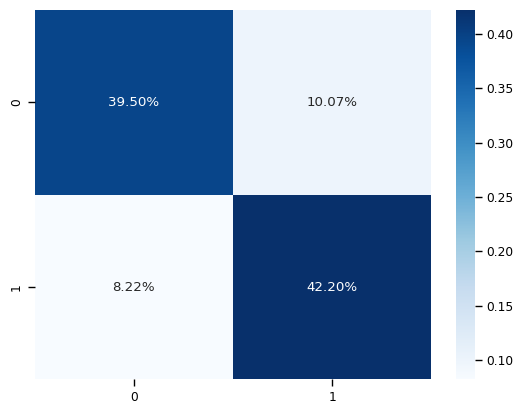

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

#Prediction and submission

In [ ]:
X_test = df2.iloc[8693:,0:-1]
X_test.sample(5)

Id_Group  Id_NumInGroup  HomePlanet_Earth  HomePlanet_Europa  \
12893      9102              1                 0                  0   
10089      2997              1                 0                  1   
11548      6287              2                 1                  0   
10402      3657              3                 0                  1   
9344       1341              2                 1                  0   

       HomePlanet_Mars  CryoSleep  C_Deck_A  C_Deck_B  C_Deck_C  C_Deck_D  \
12893                1        1.0         0         0         0         0   
10089                0        1.0         0         1         0         0   
11548                0        0.0         0         0         0         0   
10402                0        0.0         0         0         0         0   
9344                 0        1.0         0         0         0         0   

       ...  Destination_PSO J318.5-22  Destination_TRAPPIST-1e   Age  VIP  \
12893  ...                          0                        1  33.0  0.0   
10089  ...                          0                        0  25.0  0.0   
11548  ...                          0                        1  22.0  0.0   
10402  ...                          0                        1  35.0  0.0   
9344   ...                          0                        1  15.0  0.0   

       RoomService  FoodCourt  ShoppingMall    Spa  VRDeck  No_Expenses  
12893          0.0        0.0           0.0    0.0     0.0            1  
10089          0.0        0.0           0.0    0.0     0.0            1  
11548          5.0        0.0           0.0    0.0   792.0            0  
10402          0.0     5138.0           0.0  720.0  2243.0            0  
9344           0.0        0.0           0.0    0.0     0.0            1  

[5 rows x 28 columns]

In [ ]:
best_model = model_2_CB

In [ ]:
y_test_pred = best_model.predict(X_test)
y_test_bool = y_test_pred.astype(bool)

In [ ]:
df_submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Transported': y_test_bool})
output.sample(5)

PassengerId  Transported
4231     9187_01         True
1752     3718_01         True
1833     3893_02         True
3922     8543_06        False
2774     6134_01         True

In [ ]:
output.to_csv('submission_2_CB_1.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
